# Step 0 - Configuration and setup of dependencies

In [7]:
# Dependencies installation
!pip install matplotlib
!pip install pandas
!pip install torch torchvision torchaudio


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import pandas as pd

# Step 1 - review dataset

In [21]:
import pandas as pd

# Specify the path to your Parquet file
image_dir = "../datasets/easy-500"
parquet_file_path = f"{image_dir}/images.parquet"
labels_parquet_file_path = f"{image_dir}/labels.parquet"

# Load the Parquet file into a DataFrame
img_labels = pd.read_parquet(parquet_file_path, engine='pyarrow')  # or engine='fastparquet'

df_labels = pd.read_parquet(labels_parquet_file_path)

print(df_labels)

def dump_images(df):
  for i, row in df.iterrows():
    image = cv2.imdecode(np.frombuffer(row['image'], np.uint8), cv2.IMREAD_COLOR)
    success = cv2.imwrite(f'../{image_dir}/{i}.jpg', image)

# Now you can work with the DataFrame `df`
print(img_labels.head())

dump_images(img_labels)

       image_id    x    y  orientation  radius  class
0             0  269  450     0.000000      17      0
1             0  533  299     0.663225      45      1
2             0  539  427     0.610865      46      1
3             0  365  148     0.488692      45      1
4             0  472  136     2.426008      40      1
...         ...  ...  ...          ...     ...    ...
11495       499  356  363     0.575959      37      2
11496       499  477  371     2.268928      41      2
11497       499  934   74     2.076942      45      2
11498       499  525  283     0.506145      46      2
11499       499  284  397     5.916666      38      2

[11500 rows x 6 columns]
   id                                              image
0   0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1   1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2   2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3   3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4   4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00

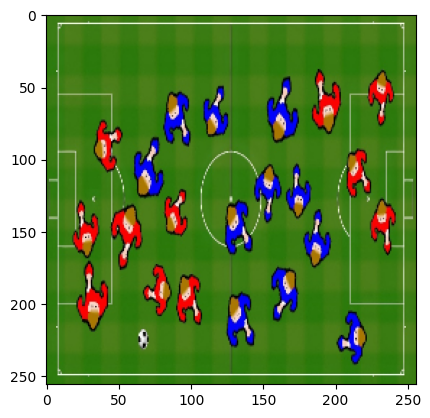

In [52]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class YOLODataset(Dataset):
    def __init__(self, parquet_path, img_dir, S=7, B=2, C=3, target_size=(256, 256)):
        # Load the annotations
        self.img_labels = pd.read_parquet(parquet_path)
        self.S = S
        self.B = B
        self.C = C
        self.img_dir = img_dir
        self.target_size = target_size
        self.property_count = 5

    def __len__(self):
        # Assuming each row in df is a separate object
        # This might need to be adjusted based on how your data is structured
        return len(self.img_labels['x'].unique())

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{int(self.img_labels.iloc[idx]['image_id'])}.jpg"

        # Load image with cv2 and convert to RGB
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image
        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)

        # Initialize the target tensor
        target = torch.zeros((self.S, self.S, self.B * (self.property_count + self.C)))
        
        # # Loop through objects (this part may need to be adjusted based on your data structure)
        # for _, row in self.df.iterrows():
        #     # Normalize x, y, and radius
        #     x, y, radius = row['x'] / self.image_size, row['y'] / self.image_size, row['radius'] / self.image_size
            
        #     # Determine the grid cell. Note: floor operation converts to int
        #     grid_x, grid_y = int(self.S * x), int(self.S * y)
            
        #     # Assuming 'class' is already an integer that can be one-hot encoded
        #     class_one_hot = torch.zeros((self.C,))
        #     class_one_hot[int(row['class'])] = 1
            
        #     # Populate the target tensor
        #     # Note: This example assumes B=1 for simplicity. You'll need to adjust it to handle multiple bounding boxes.
        #     target[grid_x, grid_y] = torch.tensor([1, x, y, radius, row['orientation'], *class_one_hot])
        
        return image, target

# Example usage
dataset = YOLODataset(parquet_path=labels_parquet_file_path, img_dir=image_dir, S=7, B=2, C=3)
image, target = dataset.__getitem__(0)
plt.imshow(image);

In [30]:
class CircleObjectsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, target_size=(256, 256)):
        self.img_labels = pd.read_parquet(annotations_file)
        self.img_dir = img_dir
        self.target_size = target_size

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{int(self.img_labels.iloc[idx]['image_id'])}.jpg"
        print(img_path)
        # Load image with cv2 and convert to RGB
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize image
        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
        # Normalize image
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))  # From HWC to CHW
        image = torch.tensor(image, dtype=torch.float)
        
        label = self.img_labels.iloc[idx][['x', 'y', 'radius', 'orientation', 'class']].values
        label = torch.tensor(label, dtype=torch.float)
        
        return image, label

# Step 2 - Setup the Model

This model is an arbitrary CNN

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 512)  # Adjust based on your target_size
        self.fc2 = nn.Linear(512, 5 + num_classes)  # x, y, radius, orientation_sin, orientation_cos, class_probs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Now lets perform our training

In [43]:
import torch.optim as optim

# Initialize your dataset and dataloader
players_dataset = CircleObjectsDataset(labels_parquet_file_path, image_dir)
image, label = players_dataset.__getitem__(0)
print(image.shape)
print(label)

train_dataloader = DataLoader(players_dataset, batch_size=4, shuffle=True)

model = SimpleCNN(num_classes=3)
criterion = nn.MSELoss()  # Placeholder for demonstration
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        print(f"input.shape: {inputs.shape}")
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0

print('Finished Training')


../datasets/easy-500/0.jpg
torch.Size([3, 256, 256])
tensor([269., 450.,  17.,   0.,   0.])
../datasets/easy-500/83.jpg
../datasets/easy-500/7.jpg
../datasets/easy-500/322.jpg
../datasets/easy-500/260.jpg
input.shape: torch.Size([4, 3, 256, 256])


/Users/danielhall/miniconda3/envs/playerdetection/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 5])) that is different to the input size (torch.Size([4, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (256) must match the size of tensor b (5) at non-singleton dimension 3